<a href="https://colab.research.google.com/github/Lakshmi-Priya-Y/FMML_projects_labs_2024/blob/main/AIML_III_Module_01_Lab_03_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DATA AUGMENTATION


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.utils.extmath import cartesian
from skimage.transform import rotate, AffineTransform, warp

rng = np.random.default_rng(seed=42)

In [2]:
#loading the dataset
(train_x,train_y),(test_x,test_y) = mnist.load_data()

#normalising the data
train_x = train_x/255
test_x = test_x/255

#subsample from images and labels.
train_x = train_x[::1200,:,:].copy()
train_y = train_y[::1200].copy()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
def nn1(traindata,trainlabel,query):
  diff = (traindata - query)
  sq = diff * diff
  dist = sq.sum(axis=1)
  label = trainlabel[np.argmin(dist)]
  return label
def nn(traindata,trainlabel,testdata):
  traindata = traindata.reshape(-1,28*28)
  testdata = testdata.reshape(-1,28*28)
  predlabel = np.array([nn1(traindata,trainlabel,i)for i in testdata])
  return predlabel
def Accuracy(gtlabel,predlabel):
  assert len(gtlabel) == len(predlabel)
  correct = (gtlabel == predlabel).sum()
  return correct/len(gtlabel)

In [4]:
testpred = nn(train_x,train_y,test_x)
print(Accuracy(test_y,testpred)*100,"%")

64.72 %


#Augmentation 1: Rotation

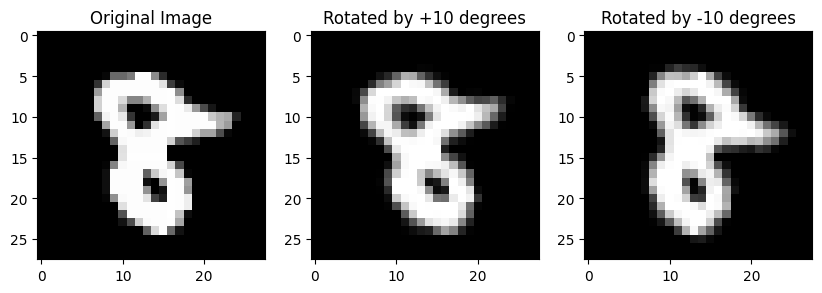

In [5]:
fig,axs =  plt.subplots(1,3,figsize=(10,3))
axs[0].imshow(train_x[2],cmap = 'gray')
axs[0].set_title("Original Image")

axs[1].imshow(rotate(train_x[2],10),cmap='gray')
axs[1].set_title("Rotated by +10 degrees")

axs[2].imshow(rotate(train_x[2],-10),cmap='gray')
axs[2].set_title("Rotated by -10 degrees")

plt.show()

A function to rotate multiple images by random angles

In [6]:
def augRotate(sample,angleconstraint):
  if angleconstraint == 0:
    return sample
  if len(sample.shape) == 2:
    #make sure the sample is 3 dimensional
    sample = np.expand_dims(sample,0)
  angle = rng.random(len(sample)) #generating random numbers for angles
  angle = (angle-0.5)*angleconstraint #converting to degrees
  nsample = sample.copy()
  for i in range(len(sample)):
    nsample[i] = rotate(sample[i],angle[i])
  return np.squeeze(nsample)

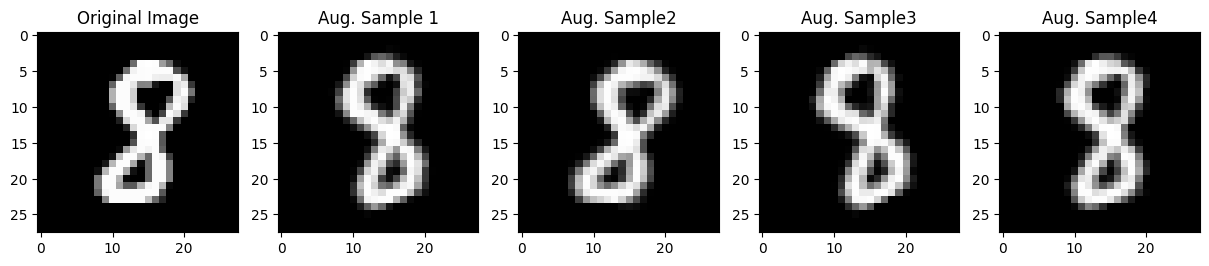

In [7]:
sample = train_x[20]
angleconstraint = 70

fig,axs = plt.subplots(1,5,figsize = (15,5))

axs[0].imshow(sample,cmap = 'gray')
axs[0].set_title("Original Image")

axs[1].imshow(augRotate(sample,angleconstraint),cmap = 'gray')
axs[1].set_title("Aug. Sample 1")

axs[2].imshow(augRotate(sample,angleconstraint),cmap = 'gray')
axs[2].set_title("Aug. Sample2")

axs[3].imshow(augRotate(sample,angleconstraint),cmap = 'gray')
axs[3].set_title("Aug. Sample3")

axs[4].imshow(augRotate(sample,angleconstraint),cmap = 'gray')
axs[4].set_title("Aug. Sample4")

plt.show()

Augmenting the whole dataset

In [8]:
#hyperparameters
angleconstraint = 60
naugmentations = 5

#augment
augdata = train_x
auglabel = train_y
for i in range(naugmentations):
  augdata = np.concatenate((augdata,augRotate(train_x,angleconstraint)))
  auglabel = np.concatenate((auglabel,train_y))
testpred = nn(augdata,auglabel,test_x)
print("Accuracy after rotation augmentation: ",Accuracy(test_y,testpred)*100,"%")

Accuracy after rotation augmentation:  67.66 %


In [9]:
angleconstraints = [0,10,20,30,40,50,60,70,80,90]
accuracies = np.zeros(len(angleconstraints),dtype=float)
for i in range(len(angleconstraints)):
  augdata = train_x
  auglabel = train_y
  for j in range(naugmentations):
    augdata = np.concatenate((augdata,augRotate(train_x,angleconstraints[i])))
    auglabel = np.concatenate((auglabel,train_y))
  testpred = nn(augdata,auglabel,test_x)
  accuracies[i] = Accuracy(test_y,testpred)
  print("Accuracy after rotation augmentation constrained by",angleconstraints[i],"degrees is ",accuracies[i]*100,"%",flush = True,)

Accuracy after rotation augmentation constrained by 0 degrees is  64.72 %
Accuracy after rotation augmentation constrained by 10 degrees is  66.79 %
Accuracy after rotation augmentation constrained by 20 degrees is  67.84 %
Accuracy after rotation augmentation constrained by 30 degrees is  68.47 %
Accuracy after rotation augmentation constrained by 40 degrees is  67.63 %
Accuracy after rotation augmentation constrained by 50 degrees is  67.65 %
Accuracy after rotation augmentation constrained by 60 degrees is  65.3 %
Accuracy after rotation augmentation constrained by 70 degrees is  66.06 %
Accuracy after rotation augmentation constrained by 80 degrees is  64.61 %
Accuracy after rotation augmentation constrained by 90 degrees is  64.31 %


Best value for angle constraint

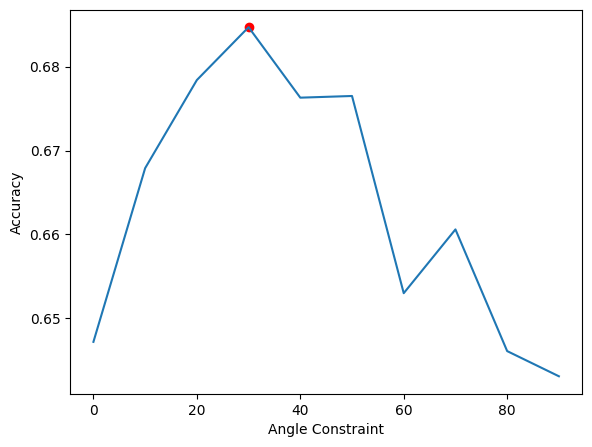

In [10]:
fig = plt.figure()
ax = fig.add_axes([0.1,0.1,0.8,0.8])
ax.plot(angleconstraints,accuracies)
ax.set_xlabel("Angle Constraint")
ax.set_ylabel("Accuracy")
maxind = np.argmax(accuracies)
plt.scatter(angleconstraints[maxind],accuracies[maxind],color = 'red')

#Augmentation 2: Shear

In [11]:
def shear(sample,amount):
  tform = AffineTransform(shear = amount)
  img = warp(sample,tform)
  col = img.sum(0).nonzero()[0]
  row = img.sum(1).nonzero()[0]
  if len(col)>0 and len(row)>0:
    xshift = int(sample.shape[0] / 2 - (row[0] + row[-1]) / 2)
    yshift = int(sample.shape[1] / 2 - (col[0] + col[-1]) / 2)
    img = np.roll(img, (xshift, yshift), (0, 1))
  return img

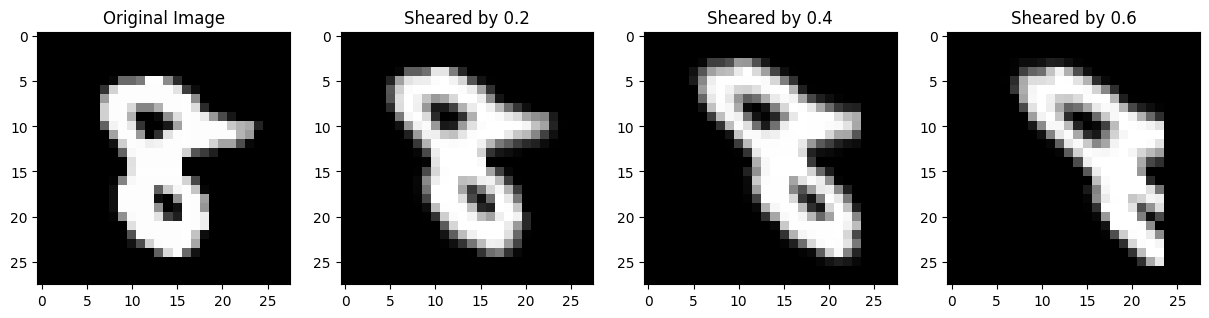

In [12]:
sample = train_x[2]
fig,axs = plt.subplots(1,4,figsize=(15,5))

axs[0].imshow(sample,cmap = 'gray')
axs[0].set_title("Original Image")

axs[1].imshow(shear(sample,0.2),cmap = 'gray')
axs[1].set_title("Sheared by 0.2")

axs[2].imshow(shear(sample,0.4),cmap = 'gray')
axs[2].set_title("Sheared by 0.4")

axs[3].imshow(shear(sample,0.6),cmap = 'gray')
axs[3].set_title("Sheared by 0.6")

plt.show()

Creating an augmentation function which applies a random shear according to the constraint we provide:

In [13]:
def augshear(sample,shearconstraint):
  if shearconstraint == 0:
    return sample
  if len(sample.shape) == 2:
    sample = np.expand_dims(sample,0)
  amt = rng.random(len(sample))
  amt = (amt - 0.5) * shearconstraint
  nsample = sample.copy()
  for ii in range(len(sample)):
    nsample[ii] = shear(sample[ii],amt[ii])
  return np.squeeze(nsample)

Grid search to find the best shear constraint

In [14]:
shearconstraints = [0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]
accuracies = np.zeros(len(shearconstraints),dtype=float)
for i in range(len(shearconstraints)):
  augdata = train_x
  auglabel = train_y
  for j in range(naugmentations):
    augdata = np.concatenate((augdata,augshear(train_x,shearconstraints[i])))
    auglabel = np.concatenate((auglabel,train_y))
    testpred = nn(augdata,auglabel,test_x)
    accuracies[i] = Accuracy(test_y,testpred)
    print("Accuracy after shear augmentation constrained by",shearconstraints[i],"is",accuracies[i]*100,"%",flush = True)

Accuracy after shear augmentation constrained by 0 is 64.72 %
Accuracy after shear augmentation constrained by 0 is 64.72 %
Accuracy after shear augmentation constrained by 0 is 64.72 %
Accuracy after shear augmentation constrained by 0 is 64.72 %
Accuracy after shear augmentation constrained by 0 is 64.72 %
Accuracy after shear augmentation constrained by 0.2 is 61.57 %
Accuracy after shear augmentation constrained by 0.2 is 61.85000000000001 %
Accuracy after shear augmentation constrained by 0.2 is 61.71 %
Accuracy after shear augmentation constrained by 0.2 is 61.760000000000005 %
Accuracy after shear augmentation constrained by 0.2 is 61.95 %
Accuracy after shear augmentation constrained by 0.4 is 61.160000000000004 %
Accuracy after shear augmentation constrained by 0.4 is 62.3 %
Accuracy after shear augmentation constrained by 0.4 is 62.89 %
Accuracy after shear augmentation constrained by 0.4 is 63.31 %
Accuracy after shear augmentation constrained by 0.4 is 63.07000000000001 %
A

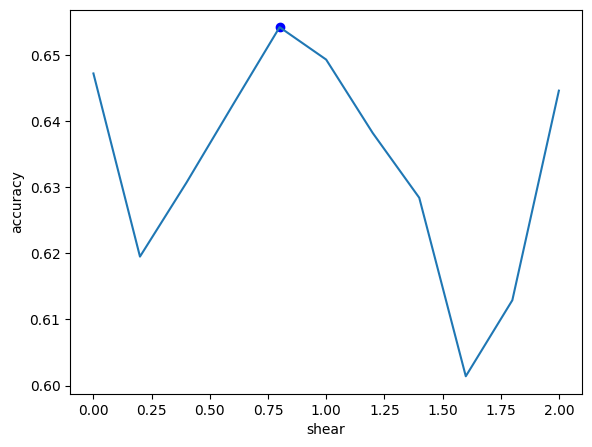

In [15]:
fig = plt.figure()
ax = fig.add_axes([0.1,0.1,0.8,0.8])
ax.plot(shearconstraints,accuracies)
ax.set_xlabel("shear")
ax.set_ylabel("accuracy")
maxind = np.argmax(accuracies)
plt.scatter(shearconstraints[maxind],accuracies[maxind],c='blue')

#Augmentation 3: Rotation + Shear

In [16]:
def augRotateShear(sample,angleconstraint,shearconstraint):
  if len(sample.shape) == 2:
    sample = np.expand_dims(sample,0)
  amt = rng.random(len(sample))
  amt = (amt - 0.5) * shearconstraint
  angle = rng.random(len(sample))
  angle = (angle - 0.5) * angleconstraint
  nsample = sample.copy()
  for ii in range(len(sample)):
    nsample[ii] = rotate(shear(sample[ii],amt[ii]),angle[ii])
  return np.squeeze(nsample)


In [17]:
shearconstraints = [
    0,
    0.2,
    0.4,
    0.6,
    0.8,
    1.0,
    1.2,
    1.4,
    1.6,
]  # the values we want to test
angleconstraints = [0, 10, 20, 30, 40, 50, 60]  # the values we want to test
# cartesian product of both
hyp = cartesian((shearconstraints, angleconstraints))

accuracies = np.zeros(len(hyp), dtype=float)  # we will save the values here

for ii in range(len(hyp)):
    # create the augmented dataset
    augdata = train_x  # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augRotateShear(train_x, hyp[ii][0], hyp[ii][1]))
        )  # concatenate the augmented data to the set
        auglabel = np.concatenate(
            (auglabel, train_y)
        )  # the labels don't change when we augment

    # check the test accuracy
    testpred = nn(augdata, auglabel, test_x)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after augmentation shear:",
        hyp[ii][0],
        "angle:",
        hyp[ii][1],
        "is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after augmentation shear: 0.0 angle: 0.0 is 63.32 %
Accuracy after augmentation shear: 0.0 angle: 10.0 is 59.419999999999995 %
Accuracy after augmentation shear: 0.0 angle: 20.0 is 58.19 %
Accuracy after augmentation shear: 0.0 angle: 30.0 is 62.35000000000001 %
Accuracy after augmentation shear: 0.0 angle: 40.0 is 60.89 %
Accuracy after augmentation shear: 0.0 angle: 50.0 is 57.620000000000005 %
Accuracy after augmentation shear: 0.0 angle: 60.0 is 60.629999999999995 %
Accuracy after augmentation shear: 0.2 angle: 0.0 is 63.41 %
Accuracy after augmentation shear: 0.2 angle: 10.0 is 59.419999999999995 %
Accuracy after augmentation shear: 0.2 angle: 20.0 is 59.19 %
Accuracy after augmentation shear: 0.2 angle: 30.0 is 58.209999999999994 %
Accuracy after augmentation shear: 0.2 angle: 40.0 is 61.12 %
Accuracy after augmentation shear: 0.2 angle: 50.0 is 58.209999999999994 %
Accuracy after augmentation shear: 0.2 angle: 60.0 is 60.91 %
Accuracy after augmentation shear: 0.4 angle

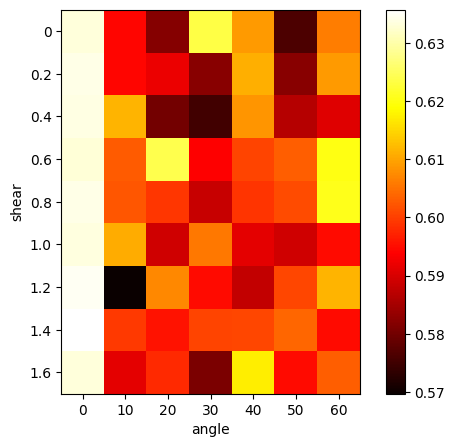

In [18]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
im = ax.imshow(accuracies.reshape((len(shearconstraints),len(angleconstraints))),cmap = "hot")
ax.set_xlabel("angle")
ax.set_ylabel("shear")
ax.set_xticks(np.arange(len(angleconstraints)))
ax.set_xticklabels(angleconstraints)
ax.set_yticks(np.arange(len(shearconstraints)))
ax.set_yticklabels(shearconstraints)
fig.colorbar(im)

In [20]:
naugmentations = 10
from skimage import exposure

def augBrightness(sample, brightness_constraint):
  if brightness_constraint == 0:
    return sample
  if len(sample.shape) == 2:
    sample = np.expand_dims(sample, 0)
  amt = rng.random(len(sample))
  amt = (amt - 0.5) * brightness_constraint
  nsample = sample.copy()
  for ii in range(len(sample)):
    nsample[ii] = exposure.adjust_gamma(sample[ii], 1 + amt[ii])
  return np.squeeze(nsample)



In [21]:
brightness_constraints = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
accuracies = np.zeros(len(brightness_constraints), dtype=float)
for i in range(len(brightness_constraints)):
  augdata = train_x
  auglabel = train_y
  for j in range(naugmentations):
    augdata = np.concatenate((augdata, augBrightness(train_x, brightness_constraints[i])))
    auglabel = np.concatenate((auglabel, train_y))
    testpred = nn(augdata, auglabel, test_x)
    accuracies[i] = Accuracy(test_y, testpred)
    print(
        "Accuracy after brightness augmentation constrained by",
        brightness_constraints[i],
        "is",
        accuracies[i] * 100,
        "%",
        flush=True,
    )

Accuracy after brightness augmentation constrained by 0 is 64.72 %
Accuracy after brightness augmentation constrained by 0 is 64.72 %
Accuracy after brightness augmentation constrained by 0 is 64.72 %
Accuracy after brightness augmentation constrained by 0 is 64.72 %
Accuracy after brightness augmentation constrained by 0 is 64.72 %
Accuracy after brightness augmentation constrained by 0 is 64.72 %
Accuracy after brightness augmentation constrained by 0 is 64.72 %
Accuracy after brightness augmentation constrained by 0 is 64.72 %
Accuracy after brightness augmentation constrained by 0 is 64.72 %
Accuracy after brightness augmentation constrained by 0 is 64.72 %
Accuracy after brightness augmentation constrained by 0.2 is 64.87 %
Accuracy after brightness augmentation constrained by 0.2 is 64.88000000000001 %
Accuracy after brightness augmentation constrained by 0.2 is 64.95 %
Accuracy after brightness augmentation constrained by 0.2 is 64.9 %
Accuracy after brightness augmentation cons